The data used in this model was a combination of election, census, and kindergarten vaccination data for the states of California, FLorida, Illinois, and Texas for the years of 2015/16 and 2019/20.  Creating the data frame used here required gathering each state's election, census, and vaccination data and creating a column of a uniform six-digit state-county fips either by combining columns already found and adding zeroes or attaching a list of county fips using the name of the county.  Additionally, the features used in the model are all percentages of the county's total relevant population and do not factor a county's raw population count in any way. The target variable, election outcome, is given a 0 if the county recieves more democratic votes and a 1 if the county recieves more republican votes. In this final model the entire 201

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
#dataframes containing census and election data 
df1516 = pd.read_csv('../../data/FINAL2016.csv')
df1920 = pd.read_csv('../../data/FINAL2020.csv')
targets = pd.read_csv('../../data/flipped.csv')
# each of the vaccination dataframes contians two columns, rate of total vaccination among kindergarteners and fips
ca2015 = pd.read_csv('../../data/vax_df/ca_vax_df_2015.csv')
fl2015 = pd.read_csv('../../data/vax_df/fl_vax_df_2015.csv')
il2015 = pd.read_csv('../../data/vax_df/il_vax_df_2015.csv')
tx2015 = pd.read_csv('../../data/vax_df/tx_vax_df_2015.csv')
ca2018 = pd.read_csv('../../data/vax_df/ca_vax_df_2018.csv')
fl2019 = pd.read_csv('../../data/vax_df/fl_vax_df_2019.csv')
il2018 = pd.read_csv('../../data/vax_df/il_vax_df_2018.csv')
tx2018 = pd.read_csv('../../data/vax_df/tx_vax_df_2018.csv')
#dataframe of which counties had a different election outcome in 2020 than in 2016
flipped = pd.read_csv('../../data/flipped.csv')

#Merging vaccination and census/election data on fip column
vax2015 = pd.concat([ca2015, fl2015, il2015, tx2015])
vax2015['fip'] = vax2015['fips']
vax2019 = pd.concat([ca2018, fl2019, il2018, tx2018])
vax2019['fip'] = vax2019['fips']
df1516 = pd.merge(vax2015, df1516, on = 'fip')
df1920 = pd.merge(vax2019, df1920, on = 'fip')


Dropping columns not used as features and setting fips to the index to retain use of it, using the entirity of the 2015/16 data as the training set and all the 2019/20 data as the test set. 

In [3]:
df1516 = df1516.set_index('FIPS')
y_train = df1516['target_2016']
X_train = df1516.drop(['Unnamed: 0', 'unnamed:_0', 'target_2016', 'fip', 'in_civilian_labor_force',
       'under_19_no_health_insurance_coverage',
       '19_to_34_years_no_health_insurance_coverage',
       '35_to_64_years_no_health_insurance_coverage', 'health_insurance_total',
       '65_years_and_over_no_health_insurance_coverage',
       'total_population_estimate', 'state_fip', 'county_fip',
       'Total Areami²', 'fips', 'total_production,_transportation,_and_material_moving_occupations',], axis=1)
df1920 = df1920.set_index('FIPS')
y_val = df1920['target_2020']
X_val = df1920.drop(['Unnamed: 0','unnamed:_0',  'target_2020', 'fip','in_civilian_labor_force',
       'under_19_no_health_insurance_coverage',
       '19_to_34_years_no_health_insurance_coverage',
       '35_to_64_years_no_health_insurance_coverage', 'health_insurance_total',
       '65_years_and_over_no_health_insurance_coverage',
       'total_population_estimate', 'state_fip', 'county_fip',
       'Total Areami²', 'total_production,_transportation,_and_material_moving_occupations', 'fips'], axis=1)


Imputing for three null values and using standard scaler 

In [4]:
scaler = StandardScaler()
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X_train)
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_imputed), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed), columns=X_val.columns, index=X_val.index)

Using SMOTE to address class imbalance with the majority of counties going to republicans in both 2016 and 2020

In [5]:
print('Original class distribution: \n')
print(y_train.value_counts(normalize=True))
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_scaled, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Resampled class distribution: \n')
print(pd.Series(y_train_resampled).value_counts(normalize=True)) 

Original class distribution: 

1    0.883886
0    0.116114
Name: target_2016, dtype: float64
-----------------------------------------
Resampled class distribution: 

1    0.5
0    0.5
Name: target_2016, dtype: float64


#the three models used on this data 
logreg = LogisticRegression(random_state=2021, solver='liblinear', penalty='l1')
dt = DecisionTreeClassifier(random_state=2021, max_depth=3)
rfc= RandomForestClassifier(random_state=2021, max_features = 'auto', n_estimators = 700)
def modeling_function(model, X_train, y_train, X_val, y_val):
    #fit model to training data
    model.fit(X_train, y_train)    #make predictions on train and validation
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)    #output metrics
    print(model,':\nTraining Recall', recall_score(y_train, train_preds))
    print('Validation Recall', recall_score(y_val, val_preds))
    print('Training Accuracy', accuracy_score(y_train, train_preds))
    print('Validation Accuracy', accuracy_score(y_val, val_preds))
    print('Training Precicion', precision_score(y_train, train_preds))
    print('Validation Precision', precision_score(y_val, val_preds))
    print('Training F1', f1_score(y_train, train_preds))
    print('Validation F1', f1_score(y_val, val_preds))
    
#determining which counties flipped from 2016 to 2020 and how accurately our model predicted the counties that flipped.
    val_preds = pd.Series(model.predict(X_val))
    val_preds.index = y_val.index
    val_results = pd.DataFrame(y_val.values, columns=['true'], index=y_val.index)
    val_results['pred'] = val_preds
    val_results = val_results.join(df1516[['target_2016']]).dropna()
    no_flip = val_results[~val_results.index.isin(flipped.FIPS_x)]
    flip = val_results[val_results.index.isin(flipped.FIPS_x)]
    flip_prediction_rate = len(flip[flip.pred != flip.target_2016])/(len(flip[flip.pred != flip.target_2016]) +len(no_flip[no_flip.pred != no_flip.target_2016]))
    print('Flip Prediction Rate', flip_prediction_rate)
    return model, flip


The baseline logreg model had a less that 1/4 chance of predicting the counties that flipped from 2016 to 2020

In [7]:
model1 = modeling_function(logreg, X_train_resampled, y_train_resampled, X_val_scaled, y_val)a

LogisticRegression(penalty='l1', random_state=2021, solver='liblinear') :
Training Recall 0.9571045576407506
Validation Recall 0.9731903485254692
Training Accuracy 0.9691689008042895
Validation Accuracy 0.9407582938388626
Training Precicion 0.9807692307692307
Validation Precision 0.9603174603174603
Training F1 0.9687924016282224
Validation F1 0.9667110519307589
Flip Prediction Rate 0.23529411764705882


A single decision tree has only a 9% chance of accurately predicting a county that flipped.

In [8]:
model2 = modeling_function(dt, X_train_resampled, y_train_resampled, X_val_scaled, y_val)

DecisionTreeClassifier(max_depth=3, random_state=2021) :
Training Recall 0.9249329758713136
Validation Recall 0.9436997319034852
Training Accuracy 0.8994638069705094
Validation Accuracy 0.8696682464454977
Training Precicion 0.8801020408163265
Validation Precision 0.9119170984455959
Training F1 0.9019607843137254
Validation F1 0.9275362318840581
Flip Prediction Rate 0.09803921568627451


The third model has a 46% chance of correctly identifying when a county will flip and when it is incorrect it is always because the model was hesitant to flip a county that should be. Every county the model predicted would flip, did.

In [9]:
model3 = modeling_function(rfc, X_train_resampled, y_train_resampled, X_val_scaled, y_val)

RandomForestClassifier(n_estimators=700, random_state=2021) :
Training Recall 1.0
Validation Recall 0.9919571045576407
Training Accuracy 1.0
Validation Accuracy 0.9597156398104265
Training Precicion 1.0
Validation Precision 0.9635416666666666
Training F1 1.0
Validation F1 0.9775429326287978
Flip Prediction Rate 0.4666666666666667


Graph depicting features used by Random Forest ranked by order of importance

<ipython-input-10-45f05e93a02d>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels);


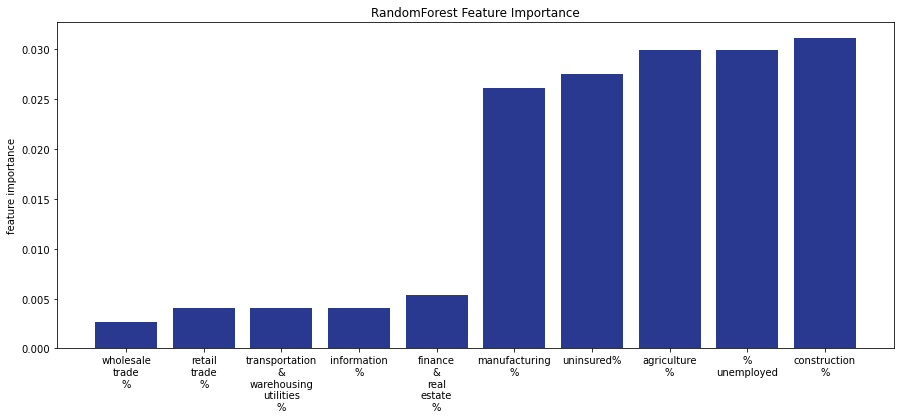

In [10]:
from sklearn.inspection import permutation_importance
results = permutation_importance(rfc, X_train_resampled, y_train_resampled, scoring='f1', random_state=2021)
rfc_importance = sorted(list(zip(X_train_resampled.columns, results.importances.ravel())), key=lambda x: x[1])
fig, ax = plt.subplots(figsize=(15,6))
x = [_[0] for _ in rfc_importance]
y = [_[1] for _ in rfc_importance]
x = x[19:]
y = y[19:]
plt.bar(x, y, color='#2A3990')
plt.title('RandomForest Feature Importance')
plt.ylabel('feature importance')
#plt.tick_params(axis=x,)
labels = ['wholesale trade %', 'retail trade %', 'transportation & warehousing utilities %','information %','finance & real estate %','manufacturing %','uninsured%', 'agriculture %', '% unemployed','construction %']
labels = [x.replace(' ', '\n') for x in labels]
ax.set_xticklabels(labels);


Confusion Matrix of what how many counties our model predicted. 

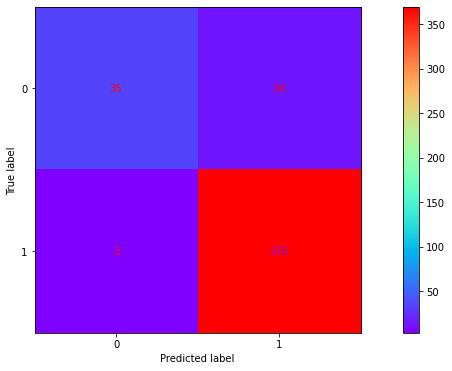

In [17]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(15,6))
plot_confusion_matrix(model3[0], X_val_scaled, y_val, ax=ax, cmap='rainbow', normalize=None)